# AudioCLIP Demo

Authored by [Andrey Guzhov](https://github.com/AndreyGuzhov)

This notebook covers common use cases of AudioCLIP and provides the typical workflow.
Below, you will find information on:

0. [Binary Assets](#Downloading-Binary-Assets)
1. [Required imports](#Imports-&-Constants)
2. [Model Instantiation](#Model-Instantiation)
3. [Data Transformation](#Audio-&-Image-Transforms)
4. Data Loading
    * [Audio](#Audio-Loading)
    * [Images](#Image-Loading)
5. [Preparation of the Input](#Input-Preparation)
6. [Acquisition of the Output](#Obtaining-Embeddings)
7. [Normalization of Embeddings](#Normalization-of-Embeddings)
8. [Calculation of Logit Scales](#Obtaining-Logit-Scales)
9. [Computation of Similarities](#Computing-Similarities)
10. Performing Tasks
    1. [Classification](#Classification)
        1. [Audio](#Audio)
        2. [Images](#Images)
    2. [Querying](#Querying)
        1. [Audio by Text](#Audio-by-Text)
        2. [Images by Text](#Images-by-Text)
        3. [Audio by Images](#Audio-by-Images)
        4. [Images by Audio](#Images-by-Audio)

## Downloading Binary Assets

In [1]:
# ! curl ../assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/bpe_simple_vocab_16e6.txt.gz
# ! curl ../assets/ https://github.com/AndreyGuzhov/AudioCLIP/releases/download/v0.1/AudioCLIP-Full-Training.pt

## Imports & Constants

In [1]:
# ! pip install ftfy

In [1]:
import os
import sys
import glob

import librosa
import librosa.display

import simplejpeg
import numpy as np

import torch
import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append(os.path.abspath(f'{os.getcwd()}/..'))

from model import AudioCLIP
from utils.transforms import ToTensor1D


torch.set_grad_enabled(False)

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'

# derived from ESResNeXt
SAMPLE_RATE = 44100

# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

LABELS = ['cat', 'thunderstorm', 'coughing', 'alarm clock', 'car horn']

## Model Instantiation

In [2]:
aclp = AudioCLIP(pretrained=f'../assets/{MODEL_FILENAME}')

## Audio & Image Transforms

In [3]:
audio_transforms = ToTensor1D()

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

## Audio Loading
Audio samples are drawn from the [ESC-50](https://github.com/karolpiczak/ESC-50) dataset.

In [4]:
paths_to_audio = glob.glob('audio/*.wav')

audio = list()
for path_to_audio in paths_to_audio:
    track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)

    # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
    # thus, the actual time-frequency representation will be visualized
    spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
    spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
    pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

    audio.append((track, pow_spec))

AttributeError: module 'librosa.display' has no attribute 'waveplot'

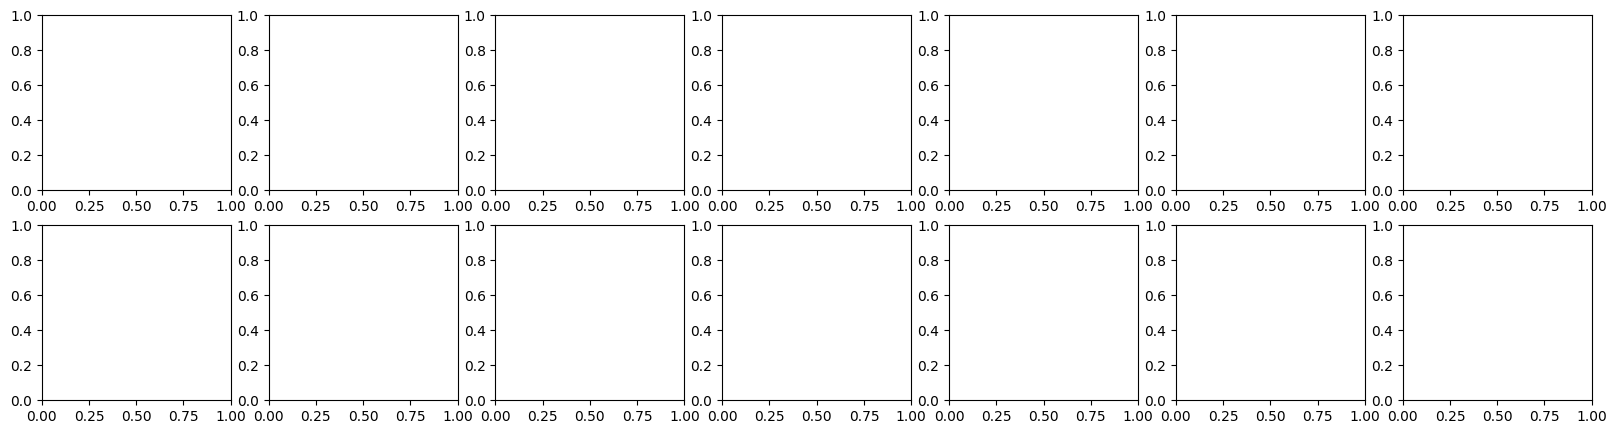

In [5]:
fig, axes = plt.subplots(2, len(audio), figsize=(20, 5), dpi=100)

for idx in range(len(audio)):
    track, pow_spec = audio[idx]

    # draw the waveform
    librosa.display.waveplot(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
    # show the corresponding power spectrogram
    axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='gray', vmin=-180.0, vmax=20.0)

    # modify legend
    axes[0, idx].set_title(os.path.basename(paths_to_audio[idx]))
    axes[0, idx].set_xlabel('')
    axes[0, idx].set_xticklabels([])
    axes[0, idx].grid(True)
    axes[0, idx].set_ylim(bottom=-1, top=1)

    axes[1, idx].set_xlabel('Time (s)')
    axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
    axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
    axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

axes[0, 0].set_ylabel('Amplitude')
axes[1, 0].set_ylabel('Filter ID')

plt.show()
plt.close(fig)

for idx, path in enumerate(paths_to_audio):
    print(os.path.basename(path))
    display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))

## Image Loading

In [8]:
paths_to_images = glob.glob('images/*.jpg')

images = list()
for path_to_image in paths_to_images:
    with open(path_to_image, 'rb') as jpg:
        image = simplejpeg.decode_jpeg(jpg.read())
        images.append(image)

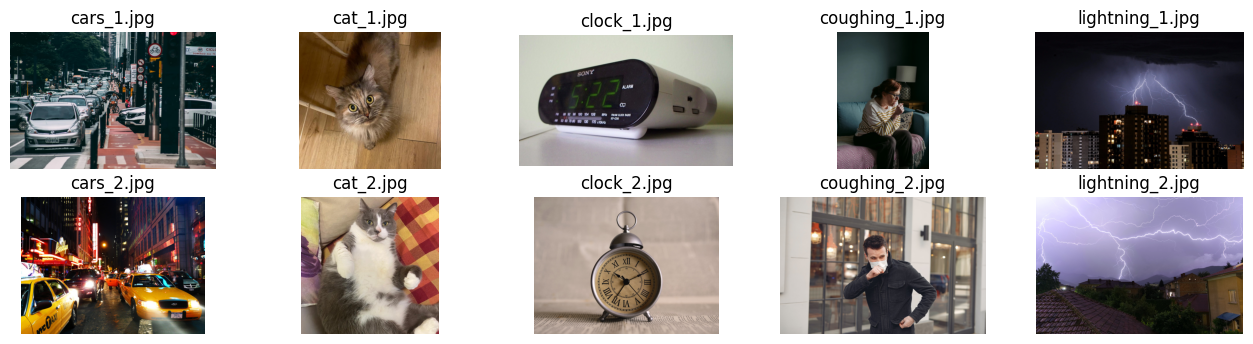

In [9]:
fig, axes = plt.subplots(2, len(images) // 2, figsize=(16, 4), dpi=100)

for idx, jdx in np.ndindex(axes.shape):
    # re-arrange order to show the images column-wise
    image_idx = np.ravel_multi_index(((jdx,), (idx,)), axes.shape[::-1]).item()
    axes[idx, jdx].imshow(images[image_idx])

    # modify legend
    axes[idx, jdx].axis('off')
    axes[idx, jdx].set_title(os.path.basename(paths_to_images[image_idx]))

plt.show()
plt.close(fig)

## Input Preparation

In [10]:
# AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio])
# standard channel-first shape [batch x channels x height x width]
images = torch.stack([image_transforms(image) for image in images])
# textual input is processed internally, so no need to transform it beforehand
text = [[label] for label in LABELS]

## Obtaining Embeddings
For the sake of clarity, all three modalities are processed separately.

In [11]:
# AudioCLIP's output: Tuple[Tuple[Features, Logits], Loss]
# Features = Tuple[AudioFeatures, ImageFeatures, TextFeatures]
# Logits = Tuple[AudioImageLogits, AudioTextLogits, ImageTextLogits]

((audio_features, _, _), _), _ = aclp(audio=audio)
((_, image_features, _), _), _ = aclp(image=images)
((_, _, text_features), _), _ = aclp(text=text)

## Normalization of Embeddings
The AudioCLIP's output is normalized using L<sub>2</sub>-norm

In [12]:
audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)

## Obtaining Logit Scales
Outputs of the text-, image- and audio-heads are made consistent using dedicated scaling terms for each pair of modalities.
The scaling factors are clamped between 1.0 and 100.0.

In [13]:
scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)

## Computing Similarities
Similarities between different representations of a same concept are computed using [scaled](#Obtaining-Logit-Scales) dot product (cosine similarity).

In [14]:
logits_audio_image = scale_audio_image * audio_features @ image_features.T
logits_audio_text = scale_audio_text * audio_features @ text_features.T
logits_image_text = scale_image_text * image_features @ text_features.T

## Classification
This task is a specific case of a more general one, which is [querying](#Querying).
However, this setup is mentioned as a standalone because it demonstrates clearly how to perform usual classification (including [zero-shot inference](https://github.com/openai/CLIP#zero-shot-prediction)) using AudioCLIP.

### Audio

In [15]:
print('\t\tFilename, Audio\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Filename, Audio			Textual Label (Confidence)

 alarm_clock_3-120526-B-37.wav ->		    alarm clock (99.87%),        car horn (00.09%),    thunderstorm (00.02%)
     car_horn_1-24074-A-43.wav ->		       car horn (96.12%),    thunderstorm (02.17%),        coughing (01.14%)
           cat_3-95694-A-5.wav ->		            cat (99.96%),        car horn (00.04%),    thunderstorm (00.00%)
     coughing_1-58792-A-24.wav ->		       coughing (99.36%),        car horn (00.56%),             cat (00.03%)
     thunder_3-144891-B-19.wav ->		   thunderstorm (99.36%),        car horn (00.38%),             cat (00.17%)


### Images

In [15]:
print('\tFilename, Image\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=1)
for image_idx in range(len(paths_to_images)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[image_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_images[image_idx]):>20s} ->\t\t'
    results = ', '.join([f'{LABELS[i]:>20s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Filename, Image			Textual Label (Confidence)

          cars_1.jpg ->		            car horn (96.09%),         thunderstorm (03.02%),                  cat (00.52%)
          cars_2.jpg ->		            car horn (99.27%),         thunderstorm (00.42%),                  cat (00.16%)
           cat_1.jpg ->		                 cat (99.62%),          alarm clock (00.16%),             car horn (00.12%)
           cat_2.jpg ->		                 cat (98.40%),             coughing (00.99%),          alarm clock (00.36%)
         clock_1.jpg ->		         alarm clock (99.76%),             car horn (00.21%),                  cat (00.01%)
         clock_2.jpg ->		         alarm clock (99.80%),             car horn (00.11%),                  cat (00.06%)
      coughing_1.jpg ->		            coughing (79.58%),          alarm clock (14.55%),                  cat (03.70%)
      coughing_2.jpg ->		            coughing (97.27%),             car horn (01.30%),         thunderstorm (00.83%)
     lightning_1.

## Querying

### Audio by Text

In [16]:
print('\t\tTextual Label\t\tFilename, Audio (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, label_idx].topk(2)

    # format output strings
    query = f'{LABELS[label_idx]:>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Textual Label		Filename, Audio (Confidence)

                      cat ->		           cat_3-95694-A-5.wav (99.25%),  alarm_clock_3-120526-B-37.wav (00.34%)
             thunderstorm ->		     thunder_3-144891-B-19.wav (98.60%),      car_horn_1-24074-A-43.wav (00.76%)
                 coughing ->		     coughing_1-58792-A-24.wav (99.78%),      car_horn_1-24074-A-43.wav (00.19%)
              alarm clock ->		 alarm_clock_3-120526-B-37.wav (100.00%),      thunder_3-144891-B-19.wav (00.00%)
                 car horn ->		     car_horn_1-24074-A-43.wav (89.28%),  alarm_clock_3-120526-B-37.wav (06.50%)


### Images by Text

In [17]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_image_text.softmax(dim=0)
for label_idx in range(len(LABELS)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[:, label_idx].topk(3)

    # format output strings
    query = f'{LABELS[label_idx]:>20s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_images[i]):>20s} ({v:>06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

                 cat ->		           cat_2.jpg (65.46%),            cat_1.jpg (34.24%),       coughing_1.jpg (00.12%)
        thunderstorm ->		     lightning_2.jpg (86.26%),      lightning_1.jpg (13.72%),            cat_2.jpg (00.00%)
            coughing ->		      coughing_2.jpg (49.51%),       coughing_1.jpg (38.11%),            cat_2.jpg (09.61%)
         alarm clock ->		         clock_1.jpg (85.85%),          clock_2.jpg (14.01%),       coughing_1.jpg (00.08%)
            car horn ->		          cars_2.jpg (36.45%),           cars_1.jpg (24.53%),          clock_1.jpg (18.69%)


### Audio by Images

In [18]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=0)
for image_idx in range(len(paths_to_images)):
    # acquire Top-2 most similar results
    conf_values, ids = confidence[:, image_idx].topk(2)

    # format output strings
    query = f'{os.path.basename(paths_to_images[image_idx]):>25s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_audio[i]):>30s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

               cars_1.jpg ->		     car_horn_1-24074-A-43.wav (63.43%),  alarm_clock_3-120526-B-37.wav (19.15%)
               cars_2.jpg ->		     car_horn_1-24074-A-43.wav (92.30%),  alarm_clock_3-120526-B-37.wav (06.56%)
                cat_1.jpg ->		           cat_3-95694-A-5.wav (99.99%),      car_horn_1-24074-A-43.wav (00.00%)
                cat_2.jpg ->		           cat_3-95694-A-5.wav (99.80%),      coughing_1-58792-A-24.wav (00.16%)
              clock_1.jpg ->		 alarm_clock_3-120526-B-37.wav (99.12%),      car_horn_1-24074-A-43.wav (00.67%)
              clock_2.jpg ->		 alarm_clock_3-120526-B-37.wav (97.73%),      thunder_3-144891-B-19.wav (01.26%)
           coughing_1.jpg ->		     coughing_1-58792-A-24.wav (76.45%),            cat_3-95694-A-5.wav (18.38%)
           coughing_2.jpg ->		     coughing_1-58792-A-24.wav (83.47%),      thunder_3-144891-B-19.wav (05.51%)
          lightning_1.jpg ->		     thunder_3-144891-B-19.wav (98.

### Images by Audio

In [19]:
print('\tTextual Label\t\t\tFilename, Image (Confidence)', end='\n\n')

# calculate model confidence
confidence = logits_audio_image.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{os.path.basename(paths_to_images[i]):>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

	Textual Label			Filename, Image (Confidence)

 alarm_clock_3-120526-B-37.wav ->		    clock_1.jpg (82.85%),     clock_2.jpg (10.75%),      cars_2.jpg (05.61%)
     car_horn_1-24074-A-43.wav ->		     cars_2.jpg (97.17%),      cars_1.jpg (01.44%),     clock_1.jpg (00.69%)
           cat_3-95694-A-5.wav ->		      cat_1.jpg (88.33%),       cat_2.jpg (11.40%),  coughing_1.jpg (00.22%)
     coughing_1-58792-A-24.wav ->		 coughing_1.jpg (69.95%),  coughing_2.jpg (20.01%),      cars_2.jpg (03.78%)
     thunder_3-144891-B-19.wav ->		lightning_1.jpg (59.54%), lightning_2.jpg (36.54%),      cars_2.jpg (01.90%)
